In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from dataclasses import dataclass
from astropy import units as u

import lilguys as lguys
from lilguys import coords
# from orbits.integrator import getPeriApoTime, getInjectionCoords, leapfrog

In [38]:
from astropy.coordinates import SkyCoord

In [12]:
cd ..

/cosma/home/durham/dc-boye1/dwarfs


In [13]:
from integrator import getPeriApoTime, getInjectionCoords, leapfrog

In [39]:
fornax_radec = SkyCoord(ra="2h39m59.3s", dec="-34d26m57s")


In [40]:
fornax_radec.ra/u.deg, fornax_radec.dec/u.deg,

(<Quantity 39.99708333>, <Quantity -34.44916667>)

In [86]:
fornax_radec = SkyCoord(ra="2h39m59.3s", dec="-34d26m57s")

fornax_obs = coords.observation(
    ra = fornax_radec.ra/u.deg,
    dec = fornax_radec.dec/u.deg,
    distance = 147,
    distance_err = 12,
    pm_ra = 0.374 ,
    pm_ra_err = 0.035 ,
    pm_dec = -0.401,
    pm_dec_err = 0.035,
    radial_velocity = 55.3,
    radial_velocity_err = 0.3
)

craterii_obs = dwarf_obs(
    ra = 177.3,
    dec = -18.4,
    distance=117.5,
    distance_err = 1.1,
    pm_ra = -0.246, 
    pm_ra_err = 0.052,
    pm_dec = -0.227,
    pm_dec_err = 0.026,
    radial_velocity = 87.5,
    radial_velocity_err = 0.4
)

NameError: name 'dwarf_obs' is not defined

In [8]:
mc_obs = coords.rand_coords(sculpter_obs, 100)

In [87]:
def periApoHist(obs):
    periSet = np.array([])
    apoSet = np.array([])
    coordSet = []

    # print('multiprocessing...',end='\r')
    # pool = mp.Pool(nCores)
    # results = np.array(pool.map(helper, coords))
    # pool.close()
    # print('done multiprocessing')
    N = len(obs)
    peris = np.empty(N)
    apos = np.empty(N)
    filt = np.full(N, False)
    for i  in range(N):
        pc = coords.to_galcen(obs[i])
        x = [pc.x, pc.y, pc.z]
        v = [pc.v_x, pc.v_y, pc.v_z]
        peri, apo, _ = getPeriApoTime(-4e9, -1e6, x, v)
        peris[i] = peri
        apos[i] = apo
        if peri is None or apo is None:
            continue
        if peri > 0 and apo > 0:
            filt[i] = True
            coordSet.append(pc)

    periSet = peris[filt]
    apoSet = apos[filt]
    return periSet,apoSet,filt


In [88]:
mc_obs = coords.rand_coords(fornax_obs, 100)

In [53]:
phases = [coords.to_galcen(o) for o in mc_obs]

In [65]:
pos = np.array([[p.x, p.y, p.z] for p in phases])
vel = np.array([[p.v_x, p.v_y, p.v_z] for p in phases])

In [68]:
snap = lguys.Snapshot(pos, vel, m=0)

In [75]:
lguys.units.V_0

207.4

In [151]:
peris, apos, filt = periApoHist(mc_obs)

In [22]:
mc_coords = []
good_obs = []
for i in range(len(filt)):
    if filt[i]:
        obs = mc_obs[i]
        good_obs.append(obs)
        mc_coords.append(coords.to_galcen(obs))

Text(0, 0.5, 'apocenter')

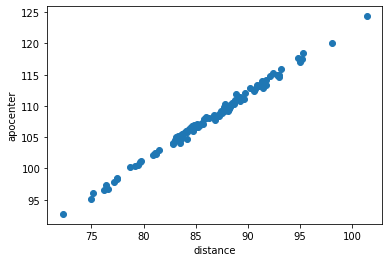

In [23]:
plt.scatter([o.distance for o in good_obs], apos)
plt.xlabel("distance")
plt.ylabel("apocenter")

In [26]:
percentiles = [16, 84]

present = {}

present["50"] = coords.to_galcen(sculpter_obs)

for per in percentiles:
    idx = np.argsort(peris)[int((len(peris) - 1) * per/100)]
    present[str(per)] = mc_coords[idx]


Text(0, 0.5, 'counts')

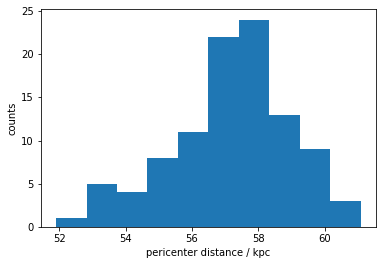

In [33]:
plt.hist(peris)
plt.xlabel("pericenter distance / kpc")
plt.ylabel("counts")

In [28]:
past = {}
apo_times = {}
for per, coord in present.items():
    x = [coord.x, coord.y, coord.z]
    v = [coord.v_x, coord.v_y, coord.v_z]
    x2, v2, apo_time = getInjectionCoords(x, v, 10, physicalUnits=True)
    past[per] = coords.phase_point(*x2, *v2)
    apo_times[per] = apo_time

In [29]:
present

{'50': [-5.20, -9.77, -85.39]kpc, 	[18.0057, 163.7410, -94.5379] km/s,
 '16': [-5.39, -9.19, -80.34]kpc, 	[19.1555, 167.9392, -95.1860] km/s,
 '84': [-4.96, -10.54, -92.08]kpc, 	[17.2523, 157.2155, -94.2006] km/s}

In [30]:
past

{'50': [15.63, 99.42, 38.37]kpc, 	[-1.1135, -50.3351, 130.9625] km/s,
 '16': [-1.09, -39.64, 94.09]kpc, 	[-21.9361, -129.5515, -54.8057] km/s,
 '84': [16.07, 110.10, 29.08]kpc, 	[0.3497, -34.8248, 131.7955] km/s}

Code unit conversion

In [121]:
phase = present["50"]

In [123]:
import lilguys

In [127]:
sc = lilguys.coords.to_skycoord(phase)

In [133]:
sc.pm_dec

<Quantity -0.401 mas / yr>

In [126]:
fornax_radec

<SkyCoord (ICRS): (ra, dec) in deg
    (39.99708333, -34.44916667)>

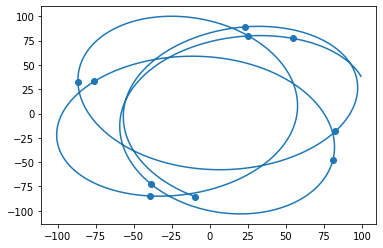

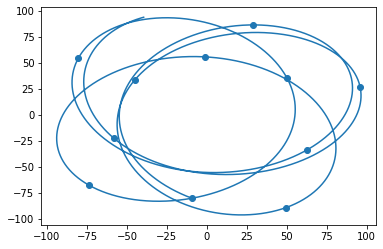

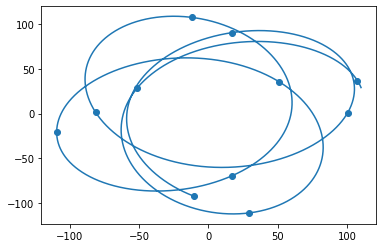

In [31]:
for per, coord in present.items():
    x = [coord.x, coord.y, coord.z]
    v = [coord.v_x, coord.v_y, coord.v_z]
    apo_time = apo_times[per]
    [xs, ys, zs, rs], vs = leapfrog(apo_time, -1e6, x, v)
    plt.plot(ys, zs)
    idxs = np.arange(0, len(xs), 1000) # 1e9 when accounting for timestep
    plt.scatter(np.array(ys)[idxs], np.array(zs)[idxs])
    plt.show()

In [163]:
snap_fornax = lguys.Output("mc_orbits/fornax/out/")

In [164]:
peris_2 = np.min(snap_fornax.r, axis=0)
apos_2 = np.max(snap_fornax.r, axis=0)

In [140]:
snap_0 = lguys.Snapshot.file("mc_orbits/fornax/positions.hdf5")

In [141]:
pos, vel = snap_0.pos, snap_0.vel

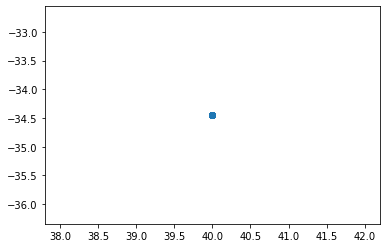

In [147]:
x = [o.ra for o in obs_out]
y = [o.dec for o in obs_out]
plt.scatter(x, y)

(array([0.00279923, 0.00668388, 0.00679813, 0.00788355, 0.00719802,
        0.00914034, 0.0105114 , 0.0027421 , 0.00228509, 0.00108542]),
 array([ 14.60251568,  32.10732789,  49.61214009,  67.1169523 ,
         84.62176451, 102.12657672, 119.63138893, 137.13620114,
        154.64101334, 172.14582555, 189.65063776]),
 [<matplotlib.patches.Polygon at 0x7fa5b768a410>])

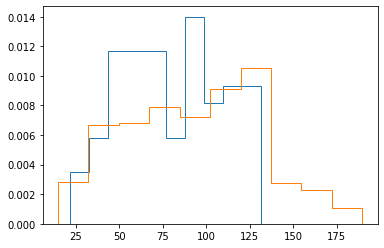

In [165]:
plt.hist(peris, histtype="step", density=True)
plt.hist(peris_2, histtype="step", density=True)

(array([6.96564753e-03, 2.09203172e-03, 1.05185953e-03, 5.49304419e-04,
        2.92183202e-04, 2.22059233e-04, 1.05185953e-04, 1.05185953e-04,
        5.84366404e-05, 4.67493123e-05, 2.33746561e-05, 2.33746561e-05,
        3.50619842e-05, 2.33746561e-05, 4.67493123e-05, 2.33746561e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.33746561e-05]),
 array([ 116.62095991,  202.18371591,  287.7464719 ,  373.3092279 ,
         458.8719839 ,  544.4347399 ,  629.9974959 ,  715.5602519 ,
         801.1230079 ,  886.6857639 ,  972.24851989, 1057.81127589,
        1143.37403189, 1228.93678789, 1314.49954389, 1400.06229989,
        1485.62505589, 1571.18781189, 1656.75056789, 1742.31332388,
        1827.87607988]),
 [<matplotlib.patches.Polygon at 0x7fa5b8788c10>])

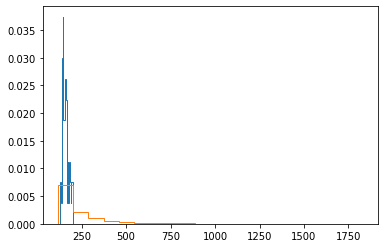

In [169]:
plt.hist(apos, 20, histtype="step", density=True)
plt.hist(apos_2, 20, histtype="step", density=True)

In [173]:
pos = snap_fornax.pos[0, :, :]
vel = snap_fornax.vel[0, :, :]

phases_out = [coords.phase_point(*p, *v) for p, v in zip(pos, vel)]
obs_out = [coords.to_sky(p) for p in phases_out]

In [174]:
ds = [o.distance for o in obs_out]

Text(0, 0.5, 'apocenters')

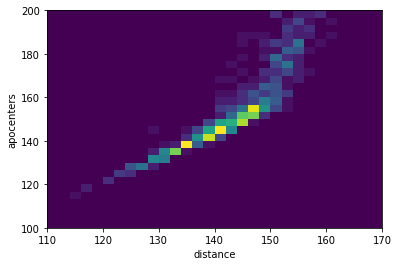

In [186]:
plt.hist2d(ds, apos_2, 30, range=((110, 170), (100, 200)))
plt.xlabel("distance")
plt.ylabel("apocenters")


In [187]:
np.percentile(peris, 16)

52.05864460693889

In [188]:
np.percentile(peris, 84)

115.01467346893595

# Sculptor Dwarf Galaxy
parameters pulled from fredrico's paper

In [202]:
from glob import glob

In [227]:
snap_i = lguys.Snapshot.file("mc_orbits/sculptor/out/snapshot_000.hdf5")
snap_f = lguys.Snapshot.file("mc_orbits/sculptor/out/snapshot_000.hdf5")

In [228]:
apos = snap_i.r
peris = snap_i.r

In [229]:
for fname in glob("mc_orbits/sculptor/out/*.hdf5"):
    snap = lguys.Snapshot.file(fname)
    apos = np.maximum(apos, snap.r)
    peris = np.minimum(peris, snap.r)

Text(0.5, 0, 'pericenters')

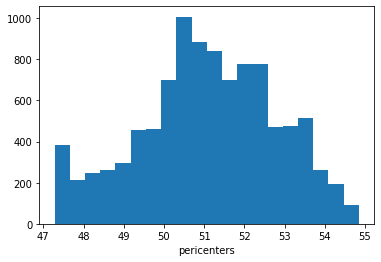

In [233]:
plt.hist(peris, 20)
plt.xlabel("pericenters")

Text(0.5, 0, 'apocenters')

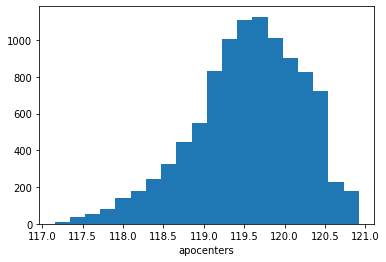

In [235]:
plt.hist(apos, 20)
plt.xlabel("apocenters")

In [ ]:
phases_0 = [coords.phase_point(*p, *v) for p, v in zip(snap_i.pos, snap_i.vel)]
observations = [coords.to_sky(p) for p in phases_0]

In [ ]:
x = [o.ra for o in observations]
y = [o.dec for o in observations]
plt.scatter(x, y)

In [ ]:
x = [o.pm_ra for o in observations]
y = [o.pm_dec for o in observations]
plt.scatter(x, y)

In [ ]:
x = [o.radial_velocity for o in observations]
y = [o.distance for o in observations]
plt.scatter(x, y)